This is a report for Assignment A1: Data Curation of the course DATA 512 of the 2021 fall quarter in MSDS at UW.

The goal of this assignment was to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 31 2021.

# Stage 1: Data Acquisition

In order to cover the full time span from January 2008 to August 2021, two APIs must be used. The first is the legacy PageCounts API - covering the period December 2007 through July 2016 - and the second is the PageViews API - covering traffic from July 2015 and beyond.

An overview and reference for the Legacy PageCounts API can be found at:
    https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts

An overview and reference for the current PageViews API can be found at:
    https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews

The schema for the endpoints of both APIs, as described in https://wikimedia.org/api/rest_v1/#/, is the following:

*/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}*

*/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}*

**project**:

    The name of any Wikimedia project formatted like {language code}.{project name}, for example en.wikipedia.

**access**:

    all-access, desktop, mobile-app, mobile-web

**access-site**:

    all-sites, desktop-site, mobile-site

**agent**:

    This parameter can be used as a filter, accepting one of the following values: all-agents, user, spider, automated. Notice this capability is not present in the legacy API.

**granularity**:

    This parameter can be set as hourly, daily, and monthly. For the purpose of this project, we are interested in monthly data.
    
**start/end**:
    
    The timestamp of the first hour/day/month to include, in YYYYMMDDHH format.

In [1]:
import json
import requests

Here we define a helper method to issue a request to the specified url, retrieve the response and save a json file.

In [2]:
def fetch_data_and_save_to_file(url, headers, access_type, start_date, end_date, file_name):
    endpoint = url.format(access = access_type, start = start_date, end = end_date)
    response = requests.get(endpoint, headers = headers)
    with open(file_name, "w") as file:
        json.dump(response.json(), file)


Although the APIs only return view counts for a specific time range, both accept queries with a start and end dates in the range we are interested in. Therefore, we can make all queries using the same time filter.

In [3]:
start_date = "2008010100"
end_date = "2021090100" # Notice we set an upper bound here for day+1 at zero hours to include the full previous day.

One of the rules of the API is that clients must send contact information through a header such as User-Agent. 

In [28]:
headers = {
    'Accept': 'application/json',
    'User-Agent': 'https://github.com/<yourusername>',  # Value removed before commit
    'From': '<email address>'                           # Value removed before commit
}

Finally, we make five calls, two to the legacy API and three to the new API, and fetch traffic metrics for desktop and mobile.

In [5]:
for access_type in ['desktop-site', 'mobile-site']:
    fetch_data_and_save_to_file(
        url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia/{access}/monthly/{start}/{end}',
        headers = headers,
        access_type = access_type,
        start_date = start_date,
        end_date = end_date,
        file_name = f"pagecounts_{access_type}_200801-202108.json")
    
for access_type in ['desktop', 'mobile-app', 'mobile-web']:
    fetch_data_and_save_to_file(
        url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/{access}/user/monthly/{start}/{end}',
        headers = headers,
        access_type = access_type,
        start_date = start_date,
        end_date = end_date,
        file_name = f"pageviews_{access_type}_200801-202108.json")

# Stage 2: Data Processing

The assignment has specific requirements regarding how the data should be formatted and eventually combined into a single CSV file. The following sections cover the necessary data processing.

In [6]:
import pandas as pd
from functools import reduce

In [7]:
def read_table(file_name):
    table = pd.read_json(file_name)

    return table['items'].apply(pd.Series)

For each of the intermediate tables, the value of the 'timestamp' is separated into four-digit 'year' (YYYY) and two-digit 'month' (MM). The original 'timestamp' along with other unnecessary columns are discarded. The column containing the view count is also renamed at this point so the tables can be merged together later.

In [8]:
def preprocess_table(file_name, views_column_name):
    table = read_table(file_name)
    
    # Rename the 'views' column.
    table.rename(columns={'views': views_column_name, 'count': views_column_name}, errors='ignore', inplace=True)
    
    # Split the timestamp into month and year
    table['year'] = table['timestamp'].apply(lambda x: x[0:4])
    table['month'] = table['timestamp'].apply(lambda x: x[4:6])
    
    table.drop(['agent', 'access', 'access-site', 'user', 'granularity', "project", "timestamp"], axis=1, errors='ignore', inplace=True)
    
    return table

In [9]:
# From the PageViews API
pageviews_desktop = preprocess_table('pageviews_desktop_200801-202108.json', 'pageview_desktop_views')
pageviews_mobile_app = preprocess_table('pageviews_mobile-app_200801-202108.json', 'pageview_mobile_app_views')
pageviews_mobile_web = preprocess_table('pageviews_mobile-web_200801-202108.json', 'pageview_mobile_web_views')

# From the Legacy PageCounts API
pagecounts_desktop = preprocess_table('pagecounts_desktop-site_200801-202108.json', 'pagecount_desktop_views')
pagecounts_mobile = preprocess_table('pagecounts_mobile-site_200801-202108.json', 'pagecount_mobile_views')

Next, all tables are joined together.

In [11]:
all_tables = [
    pageviews_desktop,
    pageviews_mobile_app,
    pageviews_mobile_web,
    pagecounts_desktop,
    pagecounts_mobile]

traffic = reduce(lambda left, right: pd.merge(left, right, on=['year', 'month'], how='outer'), all_tables).fillna(0)

For all data collected from the PageViews API, the monthly values for mobile-app and mobile-web is combined to create a total mobile view count for each month.

In [12]:
traffic['pageview_mobile_views'] = traffic['pageview_mobile_app_views'] + traffic['pageview_mobile_web_views']

Two new columns are also computed to show the total number of views (desktop + mobile) captured per API.

In [13]:
traffic['pageview_all_views'] = traffic['pageview_desktop_views'] + traffic['pageview_mobile_views']
traffic['pagecount_all_views'] = traffic['pagecount_desktop_views'] + traffic['pagecount_mobile_views']

Finally, the columns are re-ordered and the rows are sorted by year and month.

In [14]:
final_traffic_table = traffic[[
    'year', 
    'month',
    'pagecount_all_views',
    'pagecount_desktop_views',
    'pagecount_mobile_views',
    'pageview_all_views',
    'pageview_desktop_views',
    'pageview_mobile_views']]

final_traffic_table = final_traffic_table.apply(pd.to_numeric, downcast='integer')

In [15]:
final_traffic_table.sort_values(by=['year','month'], inplace=True)

The output is then exported to a CSV file.

In [17]:
final_traffic_table.to_csv("en-wikipedia_traffic_200712-202108.csv", index=False)

In [18]:
final_traffic_table

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
74,2008,1,4930902570,4930902570,0,0,0,0
75,2008,2,4818393763,4818393763,0,0,0,0
76,2008,3,4955405809,4955405809,0,0,0,0
77,2008,4,5159162183,5159162183,0,0,0,0
78,2008,5,5584691092,5584691092,0,0,0,0
...,...,...,...,...,...,...,...,...
69,2021,4,0,0,0,7641809575,2882714492,4759095083
70,2021,5,0,0,0,7800995735,2824416177,4976579558
71,2021,6,0,0,0,7090481783,2505971366,4584510417
72,2021,7,0,0,0,7544493789,2765584368,4778909421


# Stage 3: Analysis

In this stage, a visualization is provided for the monthly traffic data.

In [19]:
import datetime
import matplotlib.pyplot as plt

A new column 'date' is defined, joining the year and month information.

In [20]:
final_traffic_table['date'] = final_traffic_table.apply(lambda x: datetime.date(x['year'], x['month'], 1), axis=1)

Next, a plot of Views by Date is provided for each of the metrics (total, desktop, mobile) for each of the APIs (PageCount and PageView).

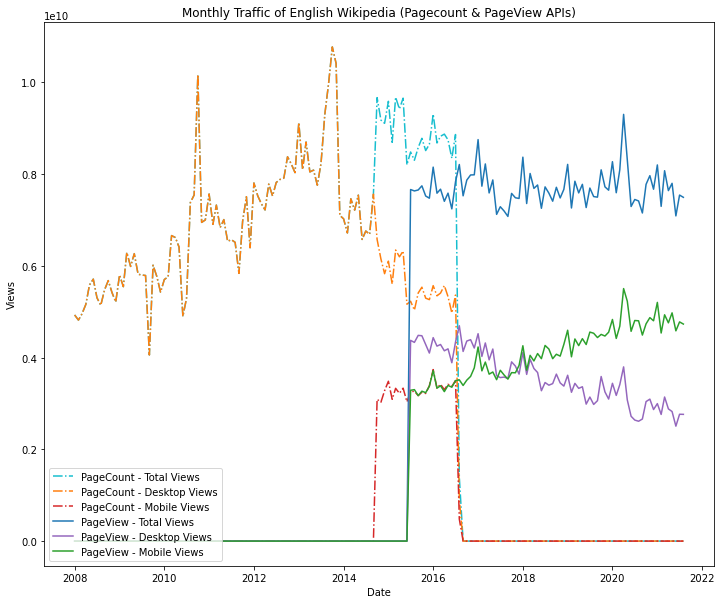

In [27]:
plt.figure(figsize=(12, 10))
plt.xlabel("Date")
plt.ylabel("Views")
plt.title("Monthly Traffic of English Wikipedia (Pagecount & PageView APIs)")
 
plt.plot(final_traffic_table.date, final_traffic_table['pagecount_all_views'], color='tab:cyan', linestyle='-.', label="PageCount - Total Views")
plt.plot(final_traffic_table.date, final_traffic_table['pagecount_desktop_views'], color='tab:orange', linestyle='-.', label="PageCount - Desktop Views")
plt.plot(final_traffic_table.date, final_traffic_table['pagecount_mobile_views'], color='tab:red', linestyle='-.', label="PageCount - Mobile Views")
plt.plot(final_traffic_table.date, final_traffic_table['pageview_all_views'], color='tab:blue', linestyle='-', label="PageView - Total Views")
plt.plot(final_traffic_table.date, final_traffic_table['pageview_desktop_views'], color='tab:purple', linestyle='-', label="PageView - Desktop Views")
plt.plot(final_traffic_table.date, final_traffic_table['pageview_mobile_views'], color='tab:green', linestyle='-', label="PageView - Mobile Views")

plt.legend(loc='lower left')    
plt.show()

Some observations from this analysis:

- The PageCount metric collection stopped around July 2016. Even though this legacy API still responds to queries, no views are reported after July 2016.
- For a few months around 2016, both APIs were functioning concurrently. It's possible to notice that *'PageCount - Mobile Views'* (in red) matches our aggregated *'PageView - Mobile Views'* (in green) during this window. This is probably the period that Wikimedia used to validate the new API before deprecating the old one, and also allow developers to transition between them.
- Both legacy and current APIs show a downwards trend in the number of views for desktop (after 2013) and an upward trend in views from mobile devices.